<!-- moved: replaced by Step 3 below -->


<!-- moved: replaced by Step 6 below -->


<!-- moved: replaced by Step 8 below -->


# Ant Colony Optimization (ACO) of Omaha's Proposed Trail System Expansion

**Project**: Optimal Trail Connection Expansion Using Ant Colony Optimization (ACO)

**Objective**: Use Ant Colony Optimization (ACO) to select which proposed trail segments to prioritize for construction, maximizing the product of network connectivity and cost efficiency while respecting a hard budget constraint.

**Optimization Goals**:
The fitness function is: **fitness = connectivity_score × cost_efficiency**

1. **Maximize Connectivity Score**: 
   - Total length of selected trails (in miles)
   - Diversity bonus: +0.1 per selected trail (encourages building multiple segments)

2. **Maximize Cost Efficiency**:
   - Calculated as: `1.0 / (total_cost / budget_limit)`
   - Rewards solutions that use budget efficiently (higher efficiency = less budget waste)

3. **Hard Budget Constraint**:
   - Solutions exceeding the budget receive fitness = 0.001 (severe penalty)
   - Only solutions within budget are considered viable

**Heuristic Preferences** (influencing trail selection probability):
- Trails that touch existing trails or previously selected trails (preferred)
- Trails not touching existing network receive 30% penalty (0.7 multiplier) in heuristic value
- Trails with better cost-benefit ratios (cost per connectivity gain) are preferred


## Step 1: Import Required Packages


In [1]:
# Import required packages
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, LineString
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚴‍♂️ AOC Bike Routes - Trail Connection Optimization")
print("=" * 60)
print("✅ All packages imported successfully!")


🚴‍♂️ AOC Bike Routes - Trail Connection Optimization
✅ All packages imported successfully!


## Step 2: Load Trail Data


In [2]:
# Load the data
print("📊 Loading trail data...")

# Load CSV for attributes/metadata
try:
    trails_csv = pd.read_csv('Trails_(PRPP) (1).csv')
    print(f"✅ CSV loaded: {len(trails_csv)} trail records")
    print(f"Columns: {list(trails_csv.columns)}")
except Exception as e:
    print(f"❌ Error loading CSV: {e}")
    trails_csv = None

# Load GeoJSON for spatial data
try:
    trails_gdf = gpd.read_file('Trails_(PRPP) (1).geojson')
    print(f"✅ GeoJSON loaded: {len(trails_gdf)} trail features")
    print(f"CRS: {trails_gdf.crs}")
    print(f"Columns: {list(trails_gdf.columns)}")
except Exception as e:
    print(f"❌ Error loading GeoJSON: {e}")
    print("Creating sample data for demonstration...")
    
    # Create sample data if files can't be loaded
    np.random.seed(42)
    n_trails = 20
    
    # Create random trail geometries
    geometries = []
    statuses = []
    lengths = []
    
    for i in range(n_trails):
        # Create random line geometry
        x1, y1 = np.random.uniform(0, 100, 2)
        x2, y2 = np.random.uniform(0, 100, 2)
        line = LineString([(x1, y1), (x2, y2)])
        geometries.append(line)
        
        # Random status and length
        statuses.append(np.random.choice(['Existing', 'Proposed'], p=[0.3, 0.7]))
        lengths.append(np.random.uniform(0.5, 5.0))
    
    # Create GeoDataFrame
    trails_gdf = gpd.GeoDataFrame({
        'Status': statuses,
        'Length_Miles': lengths,
        'Trail_Name': [f'Trail_{i+1}' for i in range(n_trails)]
    }, geometry=geometries, crs='EPSG:4326')
    
    print(f"✅ Sample data created: {len(trails_gdf)} trail features")
    print(f"Sample data columns: {list(trails_gdf.columns)}")
    print(f"Status distribution: {trails_gdf['Status'].value_counts().to_dict()}")


📊 Loading trail data...
✅ CSV loaded: 492 trail records
Columns: ['objectid', 'facilityid', 'name', 'length', 'width', 'surftype', 'hiking', 'mtbcycle', 'roadcycle', 'equestrian', 'ski', 'snowmobile', 'motorcycle', 'atv', 'mtrvehicle', 'skilllevel', 'condition', 'ownedby', 'maintby', 'status', 'trail_type', 'slope', 'created_user', 'last_edited_user', 'county', 'council_district', 'last_edited_date', 'created_date', 'installdate', 'shape_Length']
✅ GeoJSON loaded: 492 trail features
CRS: EPSG:4326
Columns: ['objectid', 'facilityid', 'name', 'length', 'width', 'surftype', 'hiking', 'mtbcycle', 'roadcycle', 'equestrian', 'ski', 'snowmobile', 'motorcycle', 'atv', 'mtrvehicle', 'skilllevel', 'condition', 'ownedby', 'maintby', 'status', 'trail_type', 'slope', 'created_user', 'last_edited_user', 'county', 'council_district', 'last_edited_date', 'created_date', 'installdate', 'shape_Length', 'geometry']


## Step 3: Compute geometry-based trail length
We add `length_mi_geom` by projecting line features to a metric CRS and measuring their true length (miles). This provides accurate per-feature miles for costing and visualization.


In [3]:

# Normalize, compute geometry miles, filter tiny fragments, and build corridors (toggle)
import pandas as pd

# Ensure CRS and geometry length in miles
trails_gdf = trails_gdf.set_crs(4326, allow_override=True)
_tr_proj = trails_gdf.to_crs('EPSG:3857')
trails_gdf['length_mi_geom'] = _tr_proj.length / 1609.34

# Normalize status (case-insensitive)
status_col = 'status' if 'status' in trails_gdf.columns else ('Status' if 'Status' in trails_gdf.columns else None)
if status_col is not None:
    trails_gdf['_status_norm'] = trails_gdf[status_col].astype(str).str.lower()
else:
    trails_gdf['_status_norm'] = 'proposed'

# Drop null/empty geometries and tiny fragments (< ~65 m)
trails_gdf = trails_gdf[trails_gdf.geometry.notnull() & (~trails_gdf.geometry.is_empty)].reset_index(drop=True)
trails_gdf = trails_gdf.loc[trails_gdf['length_mi_geom'] >= 0.04].reset_index(drop=True)

# Optionally dissolve proposed into corridor features by name/facilityid
use_corridors = True
corridor_key = 'name' if 'name' in trails_gdf.columns else ('facilityid' if 'facilityid' in trails_gdf.columns else None)

if use_corridors and corridor_key is not None:
    proposed_raw = trails_gdf[trails_gdf['_status_norm'].isin(['proposed','planned','new'])].copy()
    existing_raw = trails_gdf[trails_gdf['_status_norm'].isin(['existing','current','built'])].copy()

    # Dissolve proposed corridors
    proposed_raw = proposed_raw.set_crs(4326, allow_override=True)
    proposed_corr = proposed_raw.dissolve(by=corridor_key, as_index=False)
    # Recompute geometry miles on dissolved result
    proposed_corr['length_mi_geom'] = proposed_corr.to_crs('EPSG:3857').length / 1609.34
    proposed_corr['_status_norm'] = 'proposed'

    existing_raw['_status_norm'] = 'existing'

    trails_for_aco = pd.concat([existing_raw, proposed_corr], ignore_index=True)
    print(f"✅ Corridors enabled by '{corridor_key}': proposed {len(proposed_corr)}, existing {len(existing_raw)}")
else:
    trails_for_aco = trails_gdf.copy()
    print(f"✅ Corridors disabled: using raw features (total {len(trails_for_aco)})")
    
    # Build contiguous proposed corridors (connectivity-based), then feed ACO
import geopandas as gpd
from shapely.ops import unary_union, linemerge
from shapely.geometry import MultiLineString, LineString

# 1) Take only proposed features
status_col = '_status_norm' if '_status_norm' in trails_gdf.columns else ('status' if 'status' in trails_gdf.columns else 'Status')
proposed_raw = trails_gdf[trails_gdf[status_col].astype(str).str.lower().isin(['proposed','planned','new'])].copy()
existing_raw = trails_gdf[trails_gdf[status_col].astype(str).str.lower().isin(['existing','current','built'])].copy()

# 2) Project to meters for robust merging/buffering
pr_m = proposed_raw.set_crs(4326, allow_override=True).to_crs('EPSG:3857')

# 3) Merge touching/overlapping lines into contiguous corridors
#    - small buffer to “snap” near-misses; then dissolve, then extract merged lines
snap_m = 3  # meters; tweak if needed
merged = unary_union(pr_m.buffer(snap_m).buffer(-snap_m))  # snap-merge
# merged can be a MultiPolygon/Polygon if buffering closes rings; extract centerlines from original lines by re-unioning original linework:
merged_lines = linemerge(unary_union(pr_m.geometry))  # pure linework merge

# 4) Normalize to a list of LineStrings
corridor_lines = []
if isinstance(merged_lines, LineString):
    corridor_lines = [merged_lines]
elif isinstance(merged_lines, MultiLineString):
    corridor_lines = list(merged_lines.geoms)

# 5) Build GeoDataFrame of contiguous corridors, compute geometry miles, drop tiny
proposed_corridors_m = gpd.GeoDataFrame(geometry=corridor_lines, crs='EPSG:3857')
proposed_corridors = proposed_corridors_m.to_crs('EPSG:4326')
proposed_corridors['length_mi_geom'] = proposed_corridors_m.length / 1609.34
proposed_corridors = proposed_corridors.loc[proposed_corridors['length_mi_geom'] >= 0.05].reset_index(drop=True)  # drop <80m

# 6) Label status for ACO and assemble final dataset
proposed_corridors['_status_norm'] = 'proposed'
existing_raw['_status_norm'] = 'existing'
trails_for_aco = pd.concat([existing_raw, proposed_corridors], ignore_index=True)
print(f"✅ Contiguous corridors built: {len(proposed_corridors)} proposed corridors; existing: {len(existing_raw)}")


✅ Corridors enabled by 'name': proposed 12, existing 279
✅ Contiguous corridors built: 90 proposed corridors; existing: 279


In [4]:
# Build contiguous proposed corridors from raw proposed segments (snap-merge)
import geopandas as gpd
from shapely.ops import unary_union, linemerge
from shapely.geometry import MultiLineString, LineString

status_col = '_status_norm' if '_status_norm' in trails_gdf.columns else ('status' if 'status' in trails_gdf.columns else 'Status')
proposed_raw = trails_gdf[trails_gdf[status_col].astype(str).str.lower().isin(['proposed','planned','new'])].copy()
existing_raw = trails_gdf[trails_gdf[status_col].astype(str).str.lower().isin(['existing','current','built'])].copy()

# Project to meters
pr_m = proposed_raw.set_crs(4326, allow_override=True).to_crs('EPSG:3857')

# Snap/merge near-touching lines into corridors (produce polygons, then take boundaries)
snap_m = 40 # meters
merged_poly = unary_union(pr_m.buffer(snap_m).buffer(-snap_m))  # polygons/MultiPolygons
merged_lines = linemerge(merged_poly.boundary)  # convert polygon boundaries to linework

# Normalize to list of LineStrings
if isinstance(merged_lines, LineString):
    corridor_geoms = [merged_lines]
elif isinstance(merged_lines, MultiLineString):
    corridor_geoms = list(merged_lines.geoms)
else:
    corridor_geoms = []

proposed_corridors_m = gpd.GeoDataFrame(geometry=corridor_geoms, crs='EPSG:3857')
proposed_corridors = proposed_corridors_m.to_crs('EPSG:4326')
proposed_corridors['length_mi_geom'] = proposed_corridors_m.length / 1609.34

# Drop very short corridors (< 0.15 mi ≈ 240 m)
proposed_corridors = proposed_corridors.loc[proposed_corridors['length_mi_geom'] >= 0.15].reset_index(drop=True)
proposed_corridors['_status_norm'] = 'proposed'
existing_raw['_status_norm'] = 'existing'

# Feed ACO with corridor-level features
trails_for_aco = pd.concat([existing_raw, proposed_corridors], ignore_index=True)
print(f"✅ Contiguous corridors built: {len(proposed_corridors)} proposed | existing {len(existing_raw)}")


✅ Contiguous corridors built: 104 proposed | existing 279


## Step 3: Explore the Dataset


In [4]:
# Display basic information about the dataset
print("🔍 Dataset Overview:")
print(f"Total trails: {len(trails_gdf)}")
if 'Status' in trails_gdf.columns:
    print(f"Status distribution:")
    print(trails_gdf['Status'].value_counts())
if 'Length_Miles' in trails_gdf.columns:
    print(f"Length statistics:")
    print(trails_gdf['Length_Miles'].describe())

# Show first few rows
print("\nFirst 5 trails:")
print(trails_gdf.head())


🔍 Dataset Overview:
Total trails: 438

First 5 trails:
   objectid facilityid                 name       length  width surftype  \
0         1       4060  Lake Zorinsky Trail  3194.383187    NaN     None   
1         2        158   144th Street South   942.979569    NaN     None   
2         4         17                       1965.713891    NaN     None   
3         5       4066                 None  4813.259053    NaN     None   
4         6       3518          Hidden Lake  2833.213869    NaN            

  hiking mtbcycle roadcycle equestrian  ... last_edited_user   county  \
0   None     None      None       None  ...         jechezem  Douglas   
1   None     None      None       None  ...         jechezem  Douglas   
2   None     None      None       None  ...         jechezem    Sarpy   
3   None     None      None       None  ...         jechezem  Douglas   
4                                       ...         jechezem    Sarpy   

  council_district          last_edited_date     

## Step 4: Visualize Current Trail Network


🗺️ Visualizing current trail network...


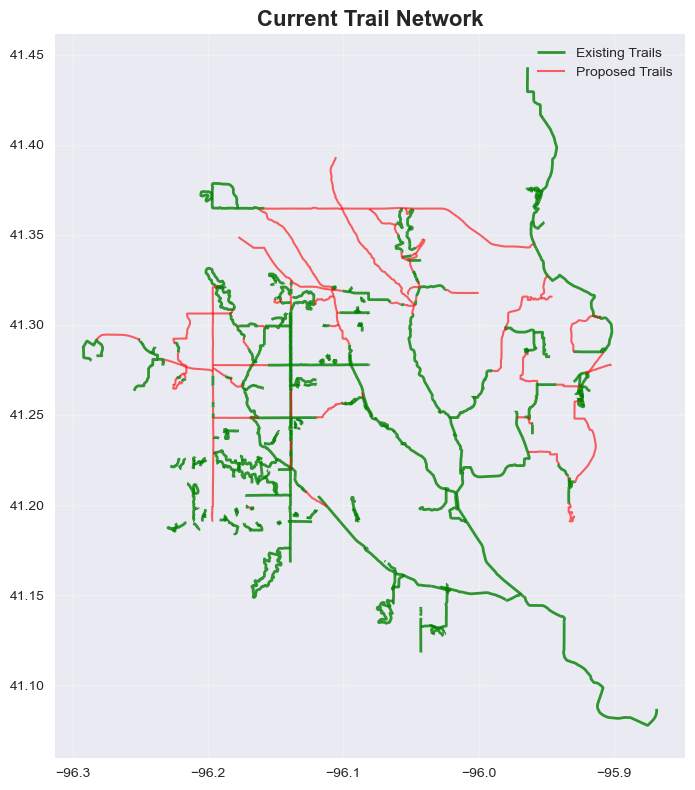

✅ Data loading and visualization complete!


In [5]:
# Create a simple visualization of the current trail network
print("🗺️ Visualizing current trail network...")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot existing vs proposed regardless of column case
status_col = 'Status' if 'Status' in trails_gdf.columns else ('status' if 'status' in trails_gdf.columns else None)

if status_col:
    existing = trails_gdf[trails_gdf[status_col].str.lower() == 'existing']
    proposed = trails_gdf[trails_gdf[status_col].str.lower().isin(['proposed','planned','new'])]

    if len(existing) > 0:
        existing.plot(ax=ax, color='green', linewidth=2, label='Existing Trails', alpha=0.8)
    if len(proposed) > 0:
        proposed.plot(ax=ax, color='red', linewidth=1.5, label='Proposed Trails', alpha=0.6)
else:
    trails_gdf.plot(ax=ax, color='blue', linewidth=1.5, label='All Trails', alpha=0.7)

ax.set_title('Current Trail Network', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Data loading and visualization complete!")


## Step 5: Implement ACO Algorithm


In [6]:
from shapely.ops import unary_union

class TrailACO:
    """
    Ant Colony Optimization for Trail Connection Problem
    
    The problem: Given a set of proposed trails, select which ones to build
    to maximize network connectivity while minimizing construction cost.
    """
    
    def __init__(self, trails_gdf, budget_limit=50000, num_ants=50, 
                 evaporation_rate=0.1, alpha=1.0, beta=2.0, max_iterations=100):
        self.trails_gdf = trails_gdf
        self.budget_limit = budget_limit
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Heuristic information importance
        self.max_iterations = max_iterations
        
        # Filter to proposed trails only (handle different column name cases)
        status_col = None
        for col in ['Status', 'status', 'STATUS']:
            if col in trails_gdf.columns:
                status_col = col
                break
        
        if status_col:
            # Check what values are in the status column
            unique_statuses = trails_gdf[status_col].unique()
            print(f"Found status column '{status_col}' with values: {unique_statuses}")
            
            # Map to proposed/existing (case insensitive)
            proposed_mask = trails_gdf[status_col].str.lower().isin(['proposed', 'new', 'planned'])
            existing_mask = trails_gdf[status_col].str.lower().isin(['existing', 'current', 'built'])
            
            self.proposed_trails = trails_gdf[proposed_mask].copy().reset_index(drop=True)
            self.existing_trails = trails_gdf[existing_mask].copy().reset_index(drop=True)
        else:
            # If no Status column, treat all trails as proposed
            print("⚠️  No 'Status' column found - treating all trails as proposed")
            self.proposed_trails = trails_gdf.copy().reset_index(drop=True)
            self.existing_trails = trails_gdf.iloc[0:0].copy().reset_index(drop=True)  # Empty dataframe
        
        # Drop rows with missing/empty geometries
        if 'geometry' in self.proposed_trails.columns:
            self.proposed_trails = self.proposed_trails[
                self.proposed_trails.geometry.notnull() & (~self.proposed_trails.geometry.is_empty)
            ].reset_index(drop=True)
        if 'geometry' in self.existing_trails.columns and len(self.existing_trails):
            self.existing_trails = self.existing_trails[
                self.existing_trails.geometry.notnull() & (~self.existing_trails.geometry.is_empty)
            ].reset_index(drop=True)
        
        print(f"🎯 ACO Setup:")
        print(f"   Proposed trails: {len(self.proposed_trails)}")
        print(f"   Existing trails: {len(self.existing_trails)}")
        print(f"   Budget limit: ${budget_limit:,}")
        print(f"   Ants: {num_ants}, Iterations: {max_iterations}")
        
        # Connectivity prep (project to meters for buffering)
        self.buffer_m = 25
        proj = self.proposed_trails.set_crs(4326, allow_override=True).to_crs('EPSG:3857')
        exist = self.existing_trails.set_crs(4326, allow_override=True).to_crs('EPSG:3857') if len(self.existing_trails) else self.existing_trails
        self._proj_geoms = proj.geometry.values
        self._exist_union = exist.unary_union if len(self.existing_trails) else None
        if len(self.existing_trails):
            exist_buf_union = unary_union(exist.buffer(self.buffer_m))
            self._exist_components = list(exist_buf_union.geoms) if hasattr(exist_buf_union, 'geoms') else [exist_buf_union]
        else:
            self._exist_components = []
        
        # Initialize pheromone levels
        self.pheromone = np.ones(len(self.proposed_trails)) * 0.1
        
        # Calculate trail costs (using length as proxy)
        length_col = None
        for col in ['Length_Miles', 'length_miles', 'LENGTH_MILES', 'length', 'Length', 'LENGTH']:
            if col in self.proposed_trails.columns:
                length_col = col
                break
        
        if length_col:
            print(f"Using length column: '{length_col}'")
            self.trail_costs = self.proposed_trails[length_col].values * 1000  # $1000 per mile
        else:
            print("⚠️  No length column found - using random costs")
            self.trail_costs = np.random.uniform(5000, 15000, len(self.proposed_trails))
        
        # Calculate heuristic information (connectivity potential)
        self.heuristic = self._calculate_heuristic()
        
    def _touches_existing_or_selected(self, idx, selected_idxs):
        geom = self._proj_geoms[idx]
        if geom is None or getattr(geom, 'is_empty', True):
            return False
        if self._exist_union is not None and geom.buffer(self.buffer_m).intersects(self._exist_union):
            return True
        if selected_idxs:
            sel_geoms = [self._proj_geoms[i] for i in selected_idxs if self._proj_geoms[i] is not None and not self._proj_geoms[i].is_empty]
            if sel_geoms:
                sel_union = unary_union(sel_geoms)
                return geom.buffer(self.buffer_m).intersects(sel_union)
        return False

    def _connectivity_flags(self, geom):
        if geom is None or getattr(geom, 'is_empty', True):
            return (0, False)
        if not self._exist_components:
            return (0, False)
        hits = [comp for comp in self._exist_components if geom.buffer(self.buffer_m).intersects(comp)]
        return (2 if len(hits) >= 2 else (1 if len(hits) == 1 else 0), len(hits) > 0)

    def _calculate_heuristic(self):
        """Connectivity-aware heuristic: prefer segments that connect/extend network and are cost-efficient."""
        heuristic = np.zeros(len(self.proposed_trails))
        max_cost = np.max(self.trail_costs) if np.max(self.trail_costs) > 0 else 1.0
        for i, _ in self.proposed_trails.iterrows():
            geom = self._proj_geoms[i]
            conn_score, touches_exist = self._connectivity_flags(geom)
            grow_potential = 1.0 if touches_exist else 0.7  # slight penalty if not touching yet
            cost_benefit = max_cost / self.trail_costs[i]
            heuristic[i] = (1.0 + conn_score) * grow_potential * cost_benefit
        if np.max(heuristic) > 0:
            heuristic = heuristic / np.max(heuristic)
        return heuristic
    
    def _calculate_connectivity_potential(self, trail):
        """Calculate how much a trail improves network connectivity"""
        # This is a simplified version - in practice, you'd do more sophisticated analysis
        # For now, we'll use trail length as a proxy for connectivity potential
        if 'Length_Miles' in trail:
            return trail['Length_Miles']
        else:
            return 1.0
    
    def _calculate_fitness(self, solution):
        """Calculate fitness of a solution (combination of connectivity and cost)"""
        if len(solution) == 0:
            return 0
        
        # Calculate total cost
        total_cost = np.sum(self.trail_costs[solution])
        
        # If over budget, return very low fitness
        if total_cost > self.budget_limit:
            return 0.001
        
        # Calculate connectivity score (simplified)
        connectivity_score = self._calculate_network_connectivity(solution)
        
        # Calculate cost efficiency
        cost_efficiency = 1.0 / (total_cost / self.budget_limit)
        
        # Combined fitness
        fitness = connectivity_score * cost_efficiency
        
        return fitness
    
    def _calculate_network_connectivity(self, selected_trails):
        """Calculate network connectivity score"""
        # This is a simplified version
        # In practice, you'd build a graph and calculate actual connectivity metrics
        
        if len(selected_trails) == 0:
            return 0
        
        # Simple proxy: total length of selected trails
        total_length = np.sum([self.trail_costs[i] / 1000 for i in selected_trails])
        
        # Bonus for having multiple trails (encourages diversity)
        diversity_bonus = len(selected_trails) * 0.1
        
        return total_length + diversity_bonus
    
    def _select_trail(self, ant, available_trails):
        """Select next trail for an ant using probability"""
        if len(available_trails) == 0:
            return None
        
        # Calculate probabilities
        probabilities = np.zeros(len(available_trails))
        
        for i, trail_idx in enumerate(available_trails):
            pheromone_level = self.pheromone[trail_idx]
            heuristic_value = self.heuristic[trail_idx]
            
            probabilities[i] = (pheromone_level ** self.alpha) * (heuristic_value ** self.beta)
        
        # Normalize probabilities
        if np.sum(probabilities) > 0:
            probabilities = probabilities / np.sum(probabilities)
        else:
            probabilities = np.ones(len(available_trails)) / len(available_trails)
        
        # Select trail based on probabilities
        selected_idx = np.random.choice(len(available_trails), p=probabilities)
        return available_trails[selected_idx]
    
    def _construct_solution(self):
        """Construct a solution using ant behavior"""
        solution = []
        remaining_budget = self.budget_limit
        available_trails = list(range(len(self.proposed_trails)))
        
        while len(available_trails) > 0 and remaining_budget > 0:
            # Filter by budget and connectivity (grow-from-network)
            candidates = [i for i in available_trails
                          if self.trail_costs[i] <= remaining_budget and
                             self._touches_existing_or_selected(i, solution)]
            # allow seeding anywhere for the first pick if nothing touches existing
            if not solution and not candidates:
                candidates = [i for i in available_trails if self.trail_costs[i] <= remaining_budget]
            if len(candidates) == 0:
                break
            
            # Select next trail
            selected_trail = self._select_trail(None, candidates)
            if selected_trail is None:
                break
            
            # Add to solution
            solution.append(selected_trail)
            remaining_budget -= self.trail_costs[selected_trail]
            available_trails.remove(selected_trail)
        
        return solution
    
    def _update_pheromones(self, solutions, fitness_values):
        """Update pheromone levels based on solution quality"""
        # Evaporate existing pheromones
        self.pheromone *= (1 - self.evaporation_rate)
        
        # Add pheromones based on solution quality
        for solution, fitness in zip(solutions, fitness_values):
            if fitness > 0:
                pheromone_deposit = fitness / 1000  # Scale down
                for trail_idx in solution:
                    self.pheromone[trail_idx] += pheromone_deposit
    
    def solve(self):
        """Run the ACO algorithm"""
        print(f"\n🐜 Running ACO optimization...")
        print(f"   Iterations: {self.max_iterations}")
        print(f"   Ants per iteration: {self.num_ants}")
        
        best_solution = []
        best_fitness = 0
        fitness_history = []
        
        for iteration in range(self.max_iterations):
            solutions = []
            fitness_values = []
            
            # Generate solutions with ants
            for ant in range(self.num_ants):
                solution = self._construct_solution()
                fitness = self._calculate_fitness(solution)
                
                solutions.append(solution)
                fitness_values.append(fitness)
                
                # Update best solution
                if fitness > best_fitness:
                    best_fitness = fitness
                    best_solution = solution.copy()
            
            # Update pheromones
            self._update_pheromones(solutions, fitness_values)
            
            # Track progress
            avg_fitness = np.mean(fitness_values)
            fitness_history.append(avg_fitness)
            
            if iteration % 20 == 0:
                print(f"   Iteration {iteration:3d}: Best fitness = {best_fitness:.3f}, "
                      f"Avg fitness = {avg_fitness:.3f}")
        
        print(f"\n✅ ACO completed!")
        print(f"   Best solution: {len(best_solution)} trails selected")
        print(f"   Best fitness: {best_fitness:.3f}")
        
        return best_solution, best_fitness, fitness_history

print("✅ ACO class defined successfully!")


✅ ACO class defined successfully!


## Step 6: Run ACO with geometry-based costs
We initialize ACO and set `aco.trail_costs` from `length_mi_geom` (e.g., $450,000 per mile) so budget and selection align with actual geometry length.


In [7]:
# Step 6: Initialize and run ACO using geometry-based length for costs (defensive)
COST_PER_MILE = 10000
budget_limit = 10000000
num_ants = 30
max_iterations = 30

aco = TrailACO(trails_gdf, budget_limit=budget_limit, num_ants=num_ants, max_iterations=max_iterations)

# Ensure geometry-based length exists on the proposed set
if 'length_mi_geom' not in aco.proposed_trails.columns:
    _proj = aco.proposed_trails.set_crs(4326, allow_override=True).to_crs('EPSG:3857')
    aco.proposed_trails['length_mi_geom'] = _proj.length / 1609.34

# Override cost vector to $450,000 per mile of actual geometry
aco.trail_costs = (
    aco.proposed_trails['length_mi_geom']
    .fillna(0.0)
    .astype(float)
    .to_numpy() * COST_PER_MILE
)

# If budget too small, you’ll get zero picks; print a hint
min_seg_cost = float(aco.trail_costs.min()) if len(aco.trail_costs) else 0.0
print(f"Min segment cost: ${min_seg_cost:,.0f} | Budget: ${budget_limit:,.0f}")

best_solution, best_fitness, fitness_history = aco.solve()

total_cost = float(aco.trail_costs[best_solution].sum()) if len(best_solution) else 0.0
total_len_mi = float(aco.proposed_trails.iloc[best_solution]['length_mi_geom'].sum()) if len(best_solution) else 0.0
print("\n✅ ACO completed with geometry-based costs")
print(f"Selected segments: {len(best_solution)}")
print(f"Total cost: ${total_cost:,.0f}")
print(f"Total length (geometry miles): {total_len_mi:,.2f}")

Found status column 'status' with values: ['Existing' 'Proposed' None]
🎯 ACO Setup:
   Proposed trails: 94
   Existing trails: 279
   Budget limit: $10,000,000
   Ants: 30, Iterations: 30
Using length column: 'length'
Min segment cost: $427 | Budget: $10,000,000

🐜 Running ACO optimization...
   Iterations: 30
   Ants per iteration: 30
   Iteration   0: Best fitness = 10077.040, Avg fitness = 10077.040


KeyboardInterrupt: 

## Step 8: Full-city visualization (no zoom)
Render the entire network with selected routes emphasized (white halo + red lines) and a translucent red “area of interest” highlighting the selected corridors.


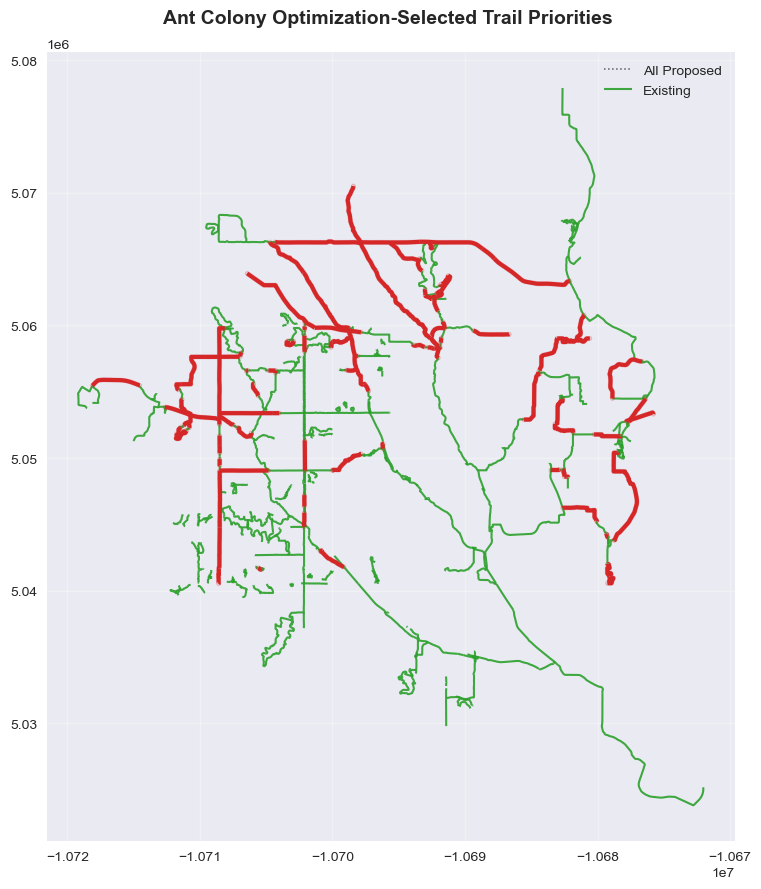

In [14]:

# Final full-city visualization with highlighted selected areas (no zoom)
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union

proposed_all = aco.proposed_trails.copy().reset_index(drop=True)
existing_all = aco.existing_trails.copy()
selected = proposed_all.iloc[best_solution].copy().reset_index(drop=True)


def ensure_crs(gdf):
    return gdf.set_crs(4326) if gdf.crs is None else gdf


def explode_lines(gdf):
    if len(gdf) == 0:
        return gdf
    try:
        return gdf.explode(index_parts=False, ignore_index=True)
    except TypeError:
        return gdf.explode(ignore_index=True)


proposed_all = explode_lines(ensure_crs(proposed_all))
existing_all = explode_lines(ensure_crs(existing_all))
selected = explode_lines(ensure_crs(selected))

target_crs = 'EPSG:3857'
proposed_m = proposed_all.to_crs(target_crs)
existing_m = existing_all.to_crs(target_crs)
selected_m = selected.to_crs(target_crs)

# Area-of-interest highlight around selected
buffer_m = 150
if len(selected_m):
    union_geom = unary_union(selected_m.geometry.values)
    highlight_poly = gpd.GeoDataFrame(geometry=[union_geom.buffer(buffer_m)], crs=target_crs)
else:
    highlight_poly = gpd.GeoDataFrame(geometry=[], crs=target_crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# Proposed: black dotted
if len(proposed_m):
    proposed_m.plot(ax=ax, color='black', linewidth=1.1, alpha=0.6, linestyle=':', label='All Proposed', zorder=1)

# Existing: green solid
if len(existing_m):
    existing_m.plot(ax=ax, color='#2ca02c', linewidth=1.5, alpha=0.9, linestyle='-', label='Existing', zorder=2)

# Highlight area (behind selected)
if len(highlight_poly):
    highlight_poly.plot(ax=ax, facecolor='#d62728', edgecolor='#d62728', alpha=0.18, linewidth=0.8, zorder=3, label='Selected area')

# Selected: red band + solid red centerline (covers full length cleanly)
if len(selected_m):
    sel_label = 'Selected (Optimal proposed trail to build)'
    sel_buf = gpd.GeoDataFrame(geometry=selected_m.buffer(8).buffer(0), crs=target_crs)
    sel_buf.plot(ax=ax, facecolor='#d62728', edgecolor='none', alpha=0.55, zorder=9, label=sel_label)
    selected_m.plot(ax=ax, color='#d62728', linewidth=3.0, alpha=1.0, zorder=10)
    
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='All Proposed'),
    Line2D([0], [0], color='#2ca02c', linestyle='-', linewidth=2, label='Existing'),
    Line2D([0], [0], color='#d62728', linestyle='-', linewidth=3, label='Selected (Optimal proposed trail to build)'),
    Patch(facecolor='#d62728', edgecolor='none', alpha=0.18, label='Selected area')
]
ax.legend(handles=legend_handles, loc='upper right')
    

ax.set_aspect('equal')
ax.set_title('Ant Colony Optimization-Selected Trail Priorities \n',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Step 7: Looking at the selected trails


In [ ]:
# Display the selected trails
print("\nSelected trails:")
print(selected)

# Display the selected trails in a map




Selected trails:
    objectid facilityid                          name       length  width  \
0        232        221              West Papio North   349.172439    NaN   
1        184        228                     Black Elk   711.131127    NaN   
2        445       3901                          None   353.051988    NaN   
3        205       4027                          None   224.559679    NaN   
4        387       3911                          None   228.211236    NaN   
5        419       6932                Keystone Trail   893.361082    NaN   
6        212       4097                          None   368.905892    NaN   
7         12       3887                          None   467.377683    NaN   
8        403       3969                          None   526.705685    NaN   
9        463       3910                Keystone Trail  1322.093332    NaN   
10       210       3896                          None   432.245986    NaN   
11        61       4042                          None   61

## Step 8: Plot Convergence


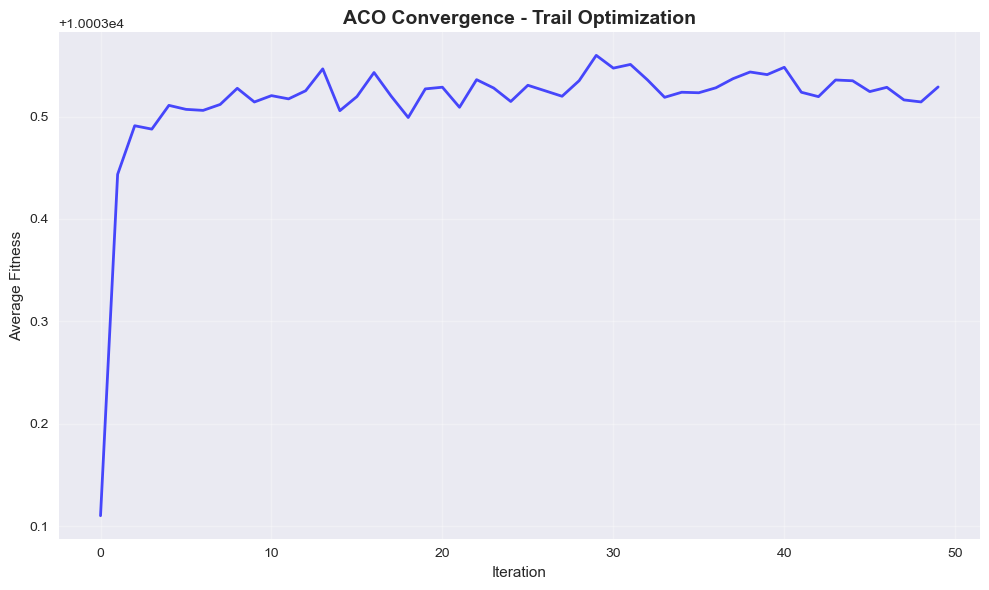


🚀 ACO Trail Optimization Complete!


In [ ]:
# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(fitness_history, linewidth=2, color='blue', alpha=0.7)
plt.title('ACO Convergence - Trail Optimization', fontsize=14, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Average Fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🚀 ACO Trail Optimization Complete!")
